In [1]:
import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal
from mne import channels, evoked, create_info
import matplotlib.pyplot as plt

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow


fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
print(epochs.info)

<Info | 22 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 acq_stim: 5 10.000000 500.000000 6 10.000000 500.000000
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0122, MEG 0123, MEG 0132, MEG 0133, MEG ...
 chs: 204 Gradiometers
 custom_ref_applied: False
 description: Vectorview system at BioMag
 dev_head_t: MEG device -> head transform
 dig: 21 items (3 Cardinal, 4 HPI, 14 Extra)
 events: 1 item (list)
 experimenter: neuromag
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2011-04-26 11:33:18 UTC
 meas_id: 4 items (dict)
 nchan: 204
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: grad_ssp_upright.fif : PCA-v1: on, grad_ssp_upright.fif : ...
 sfreq: 600.6 Hz
 subject_info: 9 items (dict)
>


In [19]:
condition_names

['Visual Upper right',
 'Visual Lower right',
 'Visual Lower left',
 'Visual Upper left',
 'Somato right',
 'Somato left',
 'Auditory right',
 'Auditory left']

In [2]:
from mneflow.layers import LFTConv, DeMixing, Dense
from tensorflow.keras.layers import Dropout

class SimpleNet(mneflow.models.LFCNN):
    def __init__(self, Dataset, specs=None):
        if specs is None:
            specs=dict()
        super().__init__(Dataset, specs)

    def build_graph(self):
        self.dmx = DeMixing(size=self.specs['n_latent'], nonlin=tf.identity,
                            axis=3, specs=self.specs)
        self.dmx_out = self.dmx(self.inputs)

        self.tconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )
        self.tconv_out = self.tconv(self.dmx_out)

        self.envconv = LFTConv(
            size=self.specs['n_latent'],
            nonlin=self.specs['nonlin'],
            filter_length=self.specs['filter_length'],
            padding=self.specs['padding'],
            specs=self.specs
        )

        self.envconv_out = self.envconv(self.tconv_out)
        self.pool = lambda X: X[:, :, ::self.specs['pooling'], :]

        self.pooled = self.pool(self.envconv_out)

        dropout = Dropout(
            self.specs['dropout'],
            noise_shape=None
        )(self.pooled)

        self.fin_fc = Dense(size=self.out_dim, nonlin=tf.identity,
                            specs=self.specs)

        y_pred = self.fin_fc(dropout)

        return y_pred

    def compute_patterns(self, data_path=None, *, output='patterns'):

        if not data_path:
            print("Computing patterns: No path specified, using validation dataset (Default)")
            ds = self.dataset.val
        elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
            ds = self.dataset._build_dataset(
                data_path,
                split=False,
                test_batch=None,
                repeat=True
            )
        elif isinstance(data_path, mneflow.data.Dataset):
            if hasattr(data_path, 'test'):
                ds = data_path.test
            else:
                ds = data_path.val
        elif isinstance(data_path, tf.data.Dataset):
            ds = data_path
        else:
            raise AttributeError('Specify dataset or data path.')

        X, y = [row for row in ds.take(1)][0]

        self.out_w_flat = self.fin_fc.w.numpy()
        self.out_weights = np.reshape(
            self.out_w_flat,
            [-1, self.dmx.size, self.out_dim]
        )
        self.out_biases = self.fin_fc.b.numpy()
        self.feature_relevances = self.componentwise_loss(X, y)

        # compute temporal convolution layer outputs for vis_dics
        tc_out = self.pool(self.tconv(self.dmx(X)).numpy())

        # compute data covariance
        X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
        X = tf.transpose(X, [3, 0, 1, 2])
        X = tf.reshape(X, [X.shape[0], -1])
        self.dcov = tf.matmul(X, tf.transpose(X))

        # get spatial extraction fiter weights
        demx = self.dmx.w.numpy()

        kern = np.squeeze(self.tconv.filters.numpy()).T

        X = X.numpy().T
        if 'patterns' in output:
            if 'old' in output:
                self.patterns = np.dot(self.dcov, demx)
            else:
                patterns = []
                X_filt = np.zeros_like(X)
                for i_comp in range(kern.shape[0]):
                    for i_ch in range(X.shape[1]):
                        x = X[:, i_ch]
                        X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                    patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
                self.patterns = np.array(patterns).T
        else:
            self.patterns = demx

        self.lat_tcs = np.dot(demx.T, X.T)

        del X

        #  Temporal conv stuff
        self.filters = kern.T
        self.tc_out = np.squeeze(tc_out)
        self.corr_to_output = self.get_output_correlations(y)

    def plot_patterns(
        self, sensor_layout=None, sorting='l2', percentile=90,
        scale=False, class_names=None, info=None
    ):
        order, ts = self._sorting(sorting)
        self.uorder = order.ravel()
        l_u = len(self.uorder)
        if info:
            info.__setstate__(dict(_unlocked=True))
            info['sfreq'] = 1.
            self.fake_evoked = evoked.EvokedArray(self.patterns, info, tmin=0)
            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        elif sensor_layout:
            lo = channels.read_layout(sensor_layout)
            info = create_info(lo.names, 1., sensor_layout.split('-')[-1])
            orig_xy = np.mean(lo.pos[:, :2], 0)
            for i, ch in enumerate(lo.names):
                if info['chs'][i]['ch_name'] == ch:
                    info['chs'][i]['loc'][:2] = (lo.pos[i, :2] - orig_xy)/3.
                    #info['chs'][i]['loc'][4:] = 0
                else:
                    print("Channel name mismatch. info: {} vs lo: {}".format(
                        info['chs'][i]['ch_name'], ch))

            self.fake_evoked = evoked.EvokedArray(self.patterns, info)

            if l_u > 1:
                self.fake_evoked.data[:, :l_u] = self.fake_evoked.data[:, self.uorder]
            elif l_u == 1:
                self.fake_evoked.data[:, l_u] = self.fake_evoked.data[:, self.uorder[0]]
            self.fake_evoked.crop(tmax=float(l_u))
            if scale:
                _std = self.fake_evoked.data[:, :l_u].std(0)
                self.fake_evoked.data[:, :l_u] /= _std
        else:
            raise ValueError("Specify sensor layout")


        if np.any(self.uorder):
            nfilt = max(self.out_dim, 8)
            nrows = max(1, l_u//nfilt)
            ncols = min(nfilt, l_u)
            if class_names:
                comp_names = class_names
            else:
                comp_names = ["Class #{}".format(jj+1) for jj in range(ncols)]
            f, ax = plt.subplots(nrows, ncols, sharey=True)
            plt.tight_layout()
            f.set_size_inches([16, 3])
            ax = np.atleast_2d(ax)

            for ii in range(nrows):
                fake_times = np.arange(ii * ncols,  (ii + 1) * ncols, 1.)
                vmax = np.percentile(self.fake_evoked.data[:, :l_u], 95)
                self.fake_evoked.plot_topomap(
                    times=fake_times,
                    axes=ax[ii],
                    colorbar=False,
                    vmax=vmax,
                    scalings=1,
                    time_format="Class #%g",
                    title='Patterns ('+str(sorting)+')',
                    outlines='head',
                )

In [3]:
#Specify import options
import_opt = dict(
    savepath='./TFR',  # path where TFR files will be saved
    out_name='mne_sample_epochs',  # name of TFRecords files
    fs=600,
    input_type='trials',
    target_type='int',
    picks={'meg':'grad'},
    scale=True,  # apply baseline_scaling
    crop_baseline=True,  # remove baseline interval after scaling
    decimate=None,
    scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
    n_folds=5,  # validation set size set to 20% of all data
    overwrite=True,
    segment=False,
    test_set='holdout'
)


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords([epochs], **import_opt)

dataset = mneflow.Dataset(meta, train_batch=100)

processing epochs
Converting picks
input shapes: X: (940, 204, 361) targets: (940,)
(940,)
Preprocessing:
Scaling to interval 0.0 - 60.0
n: 940
Splitting into: 6 folds x 156
Preprocessed: (940, 1, 301, 204) (940, 1) folds: 6 x 156
Prepocessed sample shape: (1, 301, 204)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


In [4]:
# specify model parameters
lf_params = dict(
    n_latent=32, #number of latent factors
    filter_length=50, #convolutional filter length in time samples
    nonlin = tf.nn.relu,
    padding = 'SAME',
    pooling = 5,#pooling factor
    stride = 5, #stride parameter for pooling layer
    pool_type='max',
    model_path = import_opt['savepath'],
    dropout = .5,
    l1_scope = ["weights"],
    l1=3e-3
)

model = SimpleNet(dataset, lf_params)
model.build()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 301, 204)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 301, 32)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 301, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 61, 32)
Input shape: (1, 301, 204)
y_pred: (None, 8)
Initialization complete!


Epoch 1/25
100/100 - 6s - loss: 2.0902 - cat_ACC: 0.1259 - val_loss: 2.0602 - val_cat_ACC: 0.1429 - 6s/epoch - 57ms/step
Epoch 2/25
100/100 - 4s - loss: 1.9228 - cat_ACC: 0.2065 - val_loss: 1.7666 - val_cat_ACC: 0.2302 - 4s/epoch - 43ms/step
Epoch 3/25
100/100 - 4s - loss: 1.5545 - cat_ACC: 0.4010 - val_loss: 1.4885 - val_cat_ACC: 0.4048 - 4s/epoch - 38ms/step
Epoch 4/25
100/100 - 4s - loss: 1.2650 - cat_ACC: 0.5359 - val_loss: 1.2890 - val_cat_ACC: 0.5159 - 4s/epoch - 36ms/step
Epoch 5/25
100/100 - 4s - loss: 0.9256 - cat_ACC: 0.6825 - val_loss: 1.0564 - val_cat_ACC: 0.6270 - 4s/epoch - 37ms/step
Epoch 6/25
100/100 - 4s - loss: 0.6292 - cat_ACC: 0.7958 - val_loss: 0.8915 - val_cat_ACC: 0.6984 - 4s/epoch - 36ms/step
Epoch 7/25
100/100 - 4s - loss: 0.3972 - cat_ACC: 0.8797 - val_loss: 0.7709 - val_cat_ACC: 0.7460 - 4s/epoch - 37ms/step
Epoch 8/25
100/100 - 4s - loss: 0.2575 - cat_ACC: 0.9242 - val_loss: 0.7069 - val_cat_ACC: 0.7540 - 4s/epoch - 38ms/step
Epoch 9/25
100/100 - 4s - loss: 

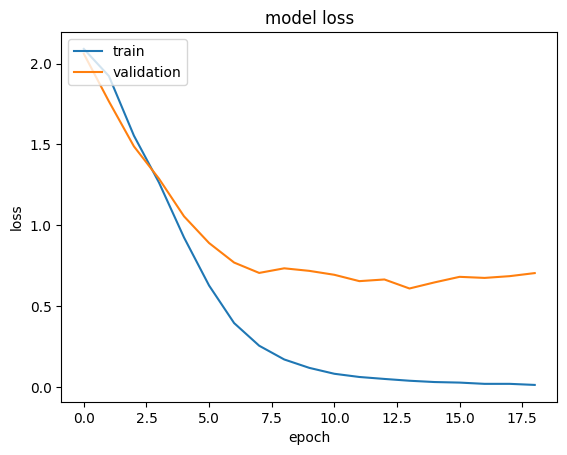

In [5]:
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [10]:
data = epochs.get_data()

In [11]:
data.shape

(940, 204, 361)

In [13]:
model.km.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 301, 204)]     0         
                                                                 
 de_mixing (DeMixing)        (None, 1, 301, 32)        6560      
                                                                 
 lft_conv (LFTConv)          (None, 1, 301, 32)        576       
                                                                 
 lft_conv_1 (LFTConv)        (None, 1, 301, 32)        576       
                                                                 
 tf.__operators__.getitem (S  (None, 1, 61, 32)        0         
 licingOpLambda)                                                 
                                                                 
 dropout (Dropout)           (None, 1, 61, 32)         0         
                                                             

In [7]:
test_loss, test_acc = model.evaluate(meta['test_paths'])

In [8]:
test_acc

0.7820512652397156

## Old way to compute patterns

In [13]:
model.compute_patterns(output='patterns old')

Computing patterns: No path specified, using validation dataset (Default)


Maximum r_spear: 0.6729110678425059
Maximum r_spear: 0.9426783536328003
Maximum r_spear: 0.6181417452962705
Maximum r_spear: 0.6225030503119338
Maximum r_spear: 0.6001911884486615
Maximum r_spear: 0.8993020471825728
Maximum r_spear: 0.6788937457604334
Maximum r_spear: 0.9483782430470455


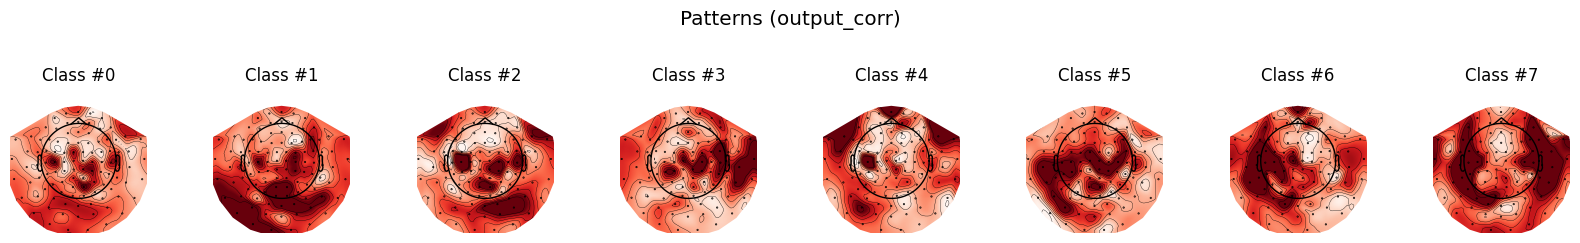

In [14]:
f1 = model.plot_patterns(info=epochs.info, sorting='output_corr')

Maximum spearman r: 0.6729110678425059
Maximum spearman r: 0.9426783536328003
Maximum spearman r: 0.6181417452962705
Maximum spearman r: 0.6225030503119338
Maximum spearman r: 0.6001911884486615
Maximum spearman r: 0.8993020471825728
Maximum spearman r: 0.6788937457604334
Maximum spearman r: 0.9483782430470455


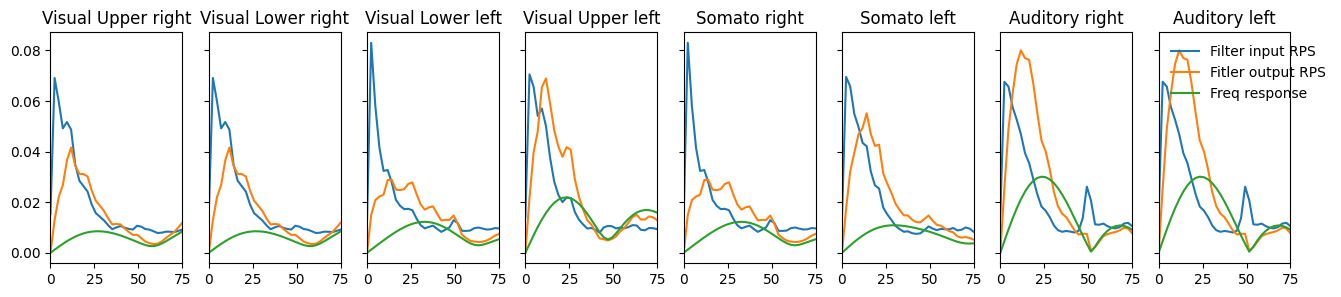

In [15]:
f2 = model.plot_spectra(sorting='weight_corr', norm_spectra='welch', class_names=condition_names)

## New way to compute patterns

In [16]:
model.compute_patterns()

Computing patterns: No path specified, using validation dataset (Default)


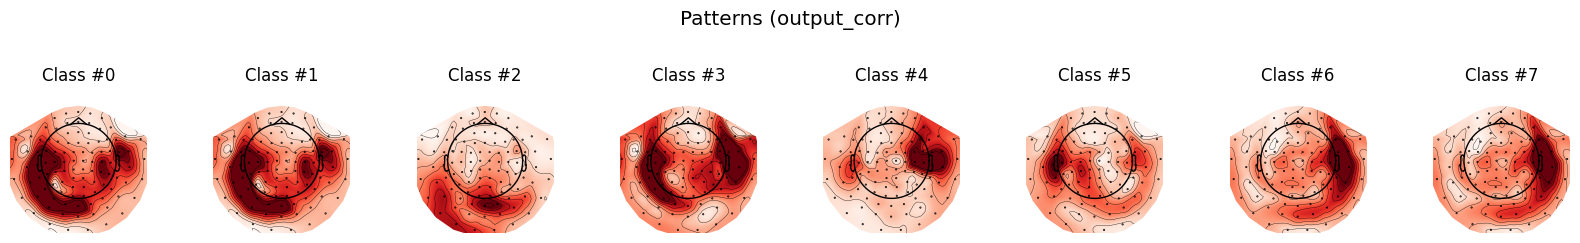

In [14]:
f1 = model.plot_patterns(info=epochs.info, sorting='output_corr')

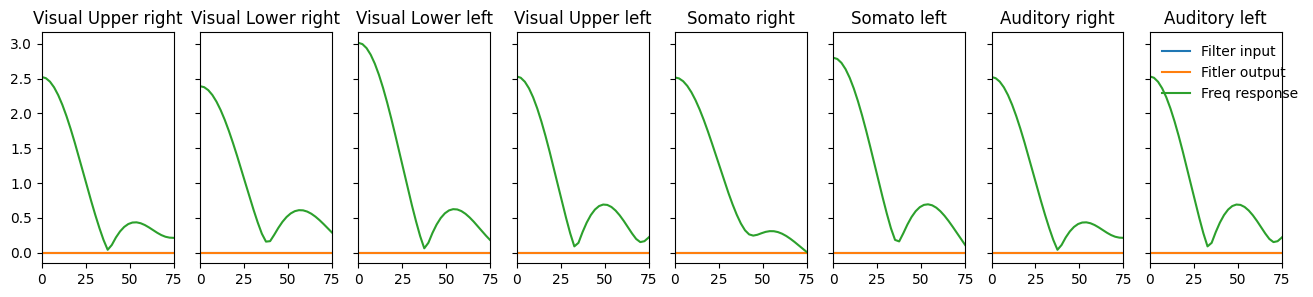

In [15]:
f2 = model.plot_spectra(sorting='weight_corr', norm_spectra='welch', class_names=condition_names)

In [6]:
import sys
import os
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)

In [7]:
from LFCNN_decoder import SpatialParameters,\
    TemporalParameters,\
    ComponentsOrder,\
    Predictions,\
    WaveForms,\
    compute_morlet_cwt,\
    compute_waveforms,\
    compute_temporal_parameters,\
    get_order
import scipy.signal as sl

def compute_patterns(model, data_path=None, *, output='patterns'):

    if not data_path:
        print("Computing patterns: No path specified, using validation dataset (Default)")
        ds = model.dataset.val
    elif isinstance(data_path, str) or isinstance(data_path, (list, tuple)):
        ds = model.dataset._build_dataset(
            data_path,
            split=False,
            test_batch=None,
            repeat=True
        )
    elif isinstance(data_path, mneflow.data.Dataset):
        if hasattr(data_path, 'test'):
            ds = data_path.test
        else:
            ds = data_path.val
    elif isinstance(data_path, tf.data.Dataset):
        ds = data_path
    else:
        raise AttributeError('Specify dataset or data path.')

    X, y = [row for row in ds.take(1)][0]

    model.out_w_flat = model.fin_fc.w.numpy()
    model.out_weights = np.reshape(
        model.out_w_flat,
        [-1, model.dmx.size, model.out_dim]
    )
    model.out_biases = model.fin_fc.b.numpy()
    model.feature_relevances = model.componentwise_loss(X, y)

    # compute temporal convolution layer outputs for vis_dics
    tc_out = model.pool(model.tconv(model.dmx(X)).numpy())

    # compute data covariance
    X = X - tf.reduce_mean(X, axis=-2, keepdims=True)
    X = tf.transpose(X, [3, 0, 1, 2])
    X = tf.reshape(X, [X.shape[0], -1])
    model.dcov = tf.matmul(X, tf.transpose(X))

    # get spatial extraction fiter weights
    demx = model.dmx.w.numpy()
    model.lat_tcs = np.dot(demx.T, X)

    kern = np.squeeze(model.tconv.filters.numpy()).T

    X = X.numpy().T
    if 'patterns' in output:
        if 'old' in output:
            model.patterns = np.dot(model.dcov, demx)
        else:
            patterns = []
            X_filt = np.zeros_like(X)
            for i_comp in range(kern.shape[0]):
                for i_ch in range(X.shape[1]):
                    x = X[:, i_ch]
                    X_filt[:, i_ch] = np.convolve(x, kern[i_comp, :], mode="same")
                patterns.append(np.cov(X_filt.T) @ demx[:, i_comp])
            model.patterns = np.array(patterns).T
    else:
        model.patterns = demx

    del X

    #  Temporal conv stuff
    model.filters = kern.T
    model.tc_out = np.squeeze(tc_out)
    model.corr_to_output = model.get_output_correlations(y)

def compute_temporal_parameters(model, *, fs=None):

    if fs is None:

        if model.dataset.h_params['fs']:
            fs = model.dataset.h_params['fs']
        else:
            print('Sampling frequency not specified, setting to 1.')
            fs = 1.

    out_filters = model.filters
    _, psd = sl.welch(model.lat_tcs, fs=fs, nperseg=fs * 2)
    finputs = psd[:, :-1]
    franges = None
    foutputs = list()
    fresponces = list()

    for i, flt in enumerate(out_filters.T):
        w, h = (lambda w, h: (w, np.abs(h)))(*sl.freqz(flt, 1, worN=fs))
        foutputs.append(np.abs(finputs[i, :] * h))

        if franges is None:
            franges = w / np.pi * fs / 2
        fresponces.append(h)

    return franges, finputs, foutputs, fresponces

def compute_waveforms(model: mneflow.models.BaseModel) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    time_courses = np.squeeze(model.lat_tcs.reshape(
        [model.specs['n_latent'], -1, model.dataset.h_params['n_t']]
    ))
    times = (1 / float(model.dataset.h_params['fs'])) *\
        np.arange(model.dataset.h_params['n_t'])
    induced = list()

    for tc in time_courses:
        ls_induced = list()

        for lc in tc:
            freqs = np.arange(1, 71)
            ls_induced.append(np.abs(compute_morlet_cwt(lc, times, freqs)))

        induced.append(np.array(ls_induced).mean(axis=0))

    return np.array(induced), times, time_courses

In [8]:


train_paths = './TFRmne_sample_epochs_train_0.tfrecord'

compute_patterns(model, train_paths)
nt = model.dataset.h_params['n_t']
time_courses = np.squeeze(model.lat_tcs.reshape([model.specs['n_latent'], -1, nt]))
times = (1 / float(model.dataset.h_params['fs'])) *\
    np.arange(model.dataset.h_params['n_t'])
patterns = model.patterns.copy()
compute_patterns(model, train_paths, output='filters')
filters = model.patterns.copy()
franges, finputs, foutputs, fresponces = compute_temporal_parameters(model)
induced, times, time_courses = compute_waveforms(model)

wf = WaveForms(time_courses.mean(1), induced, times, time_courses)
sp = SpatialParameters(patterns, filters)
tp = TemporalParameters(franges, finputs, foutputs, fresponces)
srp = ComponentsOrder(
    get_order(*model._sorting('l2')),
    get_order(*model._sorting('compwise_loss')),
    get_order(*model._sorting('weight')),
    get_order(*model._sorting('output_corr')),
    get_order(*model._sorting('weight_corr')),
)


/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:1061: RuntimeWarning: invalid value encountered in divide
  y_true = y_true/np.linalg.norm(y_true, ord=1, axis=0)[None, :]


Maximum weight: 0.08938996
Maximum weight: 0.09628295
Maximum weight: 0.10666154
Maximum weight: 0.09159265
Maximum weight: 0.13256769
Maximum weight: 0.10223417
Maximum weight: 0.10018887
Maximum weight: 0.09210323
Maximum r_spear: 1.2804606434628845
Maximum r_spear: 1.4820222144579156
Maximum r_spear: 0.0
Maximum r_spear: 0.0
Maximum r_spear: 0.0
Maximum r_spear: 0.0
Maximum r_spear: 0.0
Maximum r_spear: 0.0
Maximum spearman r: 1.2804606434628845
Maximum spearman r: 1.4820222144579156
Maximum spearman r: 0.0
Maximum spearman r: 0.0
Maximum spearman r: 0.0
Maximum spearman r: 0.0
Maximum spearman r: 0.0
Maximum spearman r: 0.0


/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:1351: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  order = np.array(order)
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.10/site-packages/mneflow/models.py:1352: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ts = np.array(ts)


QApplication: invalid style override 'kvantum' passed, ignoring it.
	Available styles: Windows, Fusion


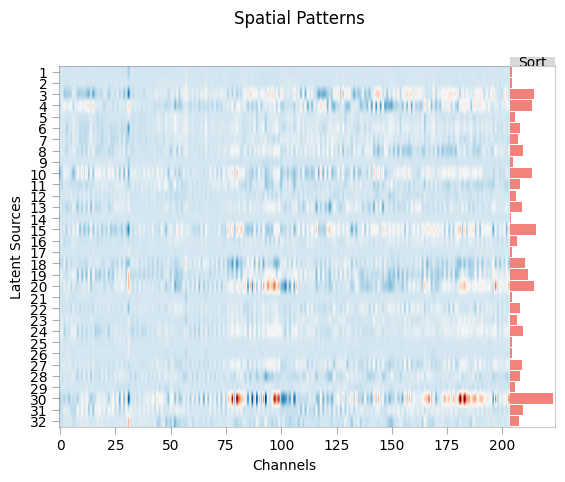

In [9]:
%matplotlib qt

from sp_vis import plot_spatial_weights

plot_spatial_weights(
    sp,
    tp,
    wf,
    epochs.info,
    summarize='sumabs',
    logscale=False
)